In [1]:
from warnings import filterwarnings
filterwarnings(action='ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

import scipy.stats as stats
from scipy.stats import zscore

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer,StandardScaler

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.metrics import classification_report,accuracy_score,precision_score,confusion_matrix
from sklearn.metrics import recall_score,f1_score,balanced_accuracy_score
from sklearn.metrics import precision_recall_curve,log_loss,roc_auc_score,roc_curve
from sklearn.metrics import classification_report

from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier

from imblearn.over_sampling import SMOTE,SMOTEN,SMOTENC,ADASYN
from imblearn.over_sampling import SVMSMOTE,BorderlineSMOTE,KMeansSMOTE
from imblearn.under_sampling import TomekLinks

import re

from sklearn.feature_selection import SelectKBest,VarianceThreshold,chi2,RFE,RFECV

from fancyimpute import IterativeImputer,knn,IterativeSVD

In [2]:
sns.set_style("darkgrid")

In [3]:
df = pd.read_csv('F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Fully_finally_imputed_data.csv')
df = df.iloc[:,1:]

In [4]:
df.shape

(100985, 50)

In [5]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'medical_specialty', 'diagnosis_1', 'diagnosis_2',
       'diagnosis_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'readmitted'],
      dtype='object')

In [6]:
patient_info = ['race', 'gender', 'age', 'admission_type_id',
                'discharge_disposition_id','admission_source_id',
                'medical_specialty','diagnosis_1','diagnosis_2', 'diagnosis_3',
                'max_glu_serum', 'A1Cresult','change', 'diabetesMed']

# Features which contains no information
drop_list_patient_info = ['encounter_id','patient_nbr','weight','payer_code']

# Numeric features
patient_info_numeric = ['time_in_hospital','num_lab_procedures',
                        'num_procedures','num_medications',
                        'number_outpatient','number_emergency',
                        'number_inpatient','number_diagnoses']

# Taking initial decision to keep 16 features
feature_medicine = ['metformin','repaglinide', 'nateglinide', 
                     'chlorpropamide', 'glimepiride', 'glipizide', 
                     'glyburide', 'tolbutamide','pioglitazone',
                     'rosiglitazone', 'acarbose', 'miglitol','tolazamide',
                     'insulin','glyburide-metformin', 'glipizide-metformin']

# Initial decision to remove 7 features
drop_list_medicine = ['acetohexamide','troglitazone','examide','citoglipton',
                      'glimepiride-pioglitazone','metformin-rosiglitazone',
                      'metformin-pioglitazone']


# The medicines which contains 'Steady' & 'No' for encoding purpose
two_category_medicine = ['acetohexamide', 'tolbutamide', 'troglitazone',
                         'glipizide-metformin', 'glimepiride-pioglitazone',
                         'metformin-rosiglitazone', 'metformin-pioglitazone']
# ------------------------------------------------------------------
# The medicines which contains 'Steady','Up','Down' & 'No' for encoding purpose (14)
four_category_medicine = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide',
                          'glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone',
                          'acarbose','miglitol','tolazamide','insulin','glyburide-metformin'] 
# ------------------------------------------------------------------
# considering these two medicines with only 'steady' & 'No' categories for encoding purpose
two_category_medicine_to_be_kept = ['tolbutamide','glipizide-metformin']
# ------------------------------------------------------------------                                                
# Out of initial removal decision, these 2 are compulsorily removed.
single_category_medicine = ['examide', 'citoglipton']
                                             

print(set(drop_list_medicine) & set(two_category_medicine))

dependent = 'readmitted'

{'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'troglitazone', 'metformin-pioglitazone', 'acetohexamide'}


In [7]:
df = df.drop(columns=drop_list_patient_info+drop_list_medicine)

In [8]:
original_Target = df['readmitted'].copy()
Target = df['readmitted'].map({'Yes':1,'No':0})
df = df.drop('readmitted',1)

In [9]:
Target.shape

(100985,)

In [10]:
df.shape

(100985, 38)

In [11]:
One_hot_encoded = df.dtypes[df.dtypes == 'object'].index.tolist()

In [12]:
# dropping Target which is at the end

# 0-28 categorical variables
# 29-36 Numerical variables
# 36 Target

logistic_transform = ColumnTransformer([('OHE',OneHotEncoder(sparse=False,drop='first'),
                                         One_hot_encoded),('std',StandardScaler(),patient_info_numeric)],
                                      remainder='passthrough')
encoded_data = logistic_transform.fit_transform(df)

In [13]:
# getting column names

category_encoded = logistic_transform.named_transformers_.OHE.get_feature_names_out()
standardized = logistic_transform.named_transformers_.std.get_feature_names_out()

# creating a encoded Dataframe

df_log = pd.DataFrame(encoded_data,columns=np.append(category_encoded,standardized))

In [14]:
df_log.shape

(100985, 110)

In [15]:
df_log.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),...,change_No,diabetesMed_Yes,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-1.136581,-0.104820,-0.786276,-1.847417,-0.291058,-0.212237,-0.502370,-3.313087
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.465257,0.810536,-0.786276,0.243574,-0.291058,-0.212237,-0.502370,0.818414
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,-0.800919,-1.630415,2.140751,-0.371423,1.285665,-0.212237,0.290327,-0.730899
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,-0.800919,0.047739,-0.200870,-0.002425,-0.291058,-0.212237,-0.502370,-0.214461
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,-1.136581,0.403711,-0.786276,-0.986421,-0.291058,-0.212237,-0.502370,-1.247336


### Target

In [16]:
Target_imbalanced = Target.copy()

In [17]:
Target_imbalanced.shape

(100985,)

In [18]:
def split(predictor,Target,testing_size=0.25,stratify=True):
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(predictor,Target,test_size=testing_size,stratify=Target,
                                                    random_state=93)
        return X_train, X_test, y_train, y_test
    else:
        X_train, X_test, y_train, y_test = train_test_split(predictor,Target,test_size=testing_size,random_state=93)
        return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split(df_log,Target_imbalanced)

In [19]:
def Imbalanced_metrics(Model,predictors,Actual,prob_threshold=0.5):
    predictions = np.where(Model.predict_proba(predictors)[:,1] > prob_threshold,1,0)
    f1 = f1_score(Actual,predictions)
    precision = precision_score(Actual,predictions)
    recall = recall_score(Actual,predictions)
    return precision,recall,f1

In [20]:
def classifier_report(Model,predictors,Actual,prob_threshold=0.5):
    predictions = np.where(Model.predict_proba(predictors)[:,1]>prob_threshold,1,0)
    print(classification_report(Actual,predictions))

In [21]:
def cv_report(Model,Training_data,Target_imbalanced):
    X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_imbalanced,
                                                        test_size=0.25, random_state=42,
                                                       stratify=Target_imbalanced)
    ba = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),
                         scoring='balanced_accuracy').mean()
    pr = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='precision').mean()
    re = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='recall').mean()
    f1 = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='f1').mean()
    print("Metric            :  percentage")
    print("-"*35)
    print(f"Balanced accuracy :  {ba*100:0.2f} %")
    print(f"Precision         :  {pr*100:0.2f} %")
    print(f"recall            :  {re*100:0.2f} %")
    print(f"F1-score          :  {f1*100:0.2f} %")

### `Model with Full Predictors`

In [22]:
Full_model = LogisticRegression(class_weight='balanced')

In [23]:
X_train, X_test, y_train, y_test = split(df_log,Target_imbalanced)

Full_model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [24]:
classifier_report(Full_model,X_train,y_train,prob_threshold=0.5)

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     67253
           1       0.17      0.56      0.26      8485

    accuracy                           0.65     75738
   macro avg       0.55      0.61      0.51     75738
weighted avg       0.84      0.65      0.71     75738



In [25]:
cv_report(Full_model,df_log,Target_imbalanced)

Metric            :  percentage
-----------------------------------
Balanced accuracy :  60.29 %
Precision         :  16.87 %
recall            :  54.41 %
F1-score          :  25.75 %


In [26]:
def threshold_plot(Model,X_train,y_train,title):
    probabilty_thresholds = np.arange(0.1,0.5,0.01)
    plotting_dict = dict()
    for prob in probabilty_thresholds:
        metric_1,metric_2,metric_3 = Imbalanced_metrics(Model,X_train,y_train,prob_threshold=prob)
        plotting_dict[prob] = metric_1,metric_2,metric_3

    plt.figure(figsize=(6,5))
    for label,values in zip(['precision','recall','f1-score'],list(zip(*tuple(plotting_dict.values())))):
        sns.lineplot(probabilty_thresholds,values,label=label)
    plt.title(title)
    plt.xlabel("Probability Thresholds",fontsize=12.0)
    plt.ylabel("Precision, Recall & F1 score",fontsize=12.0)
    return plt.show()

In [27]:
title = "Metrics for different Probability threshold \n Logistic Regression on Training Data(Imbalanced) \n class_weight = 'balanced'"

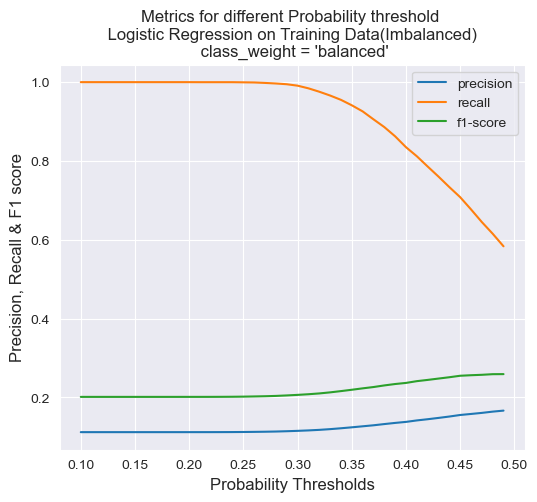

In [28]:
threshold_plot(Full_model,X_train,y_train,title=title)

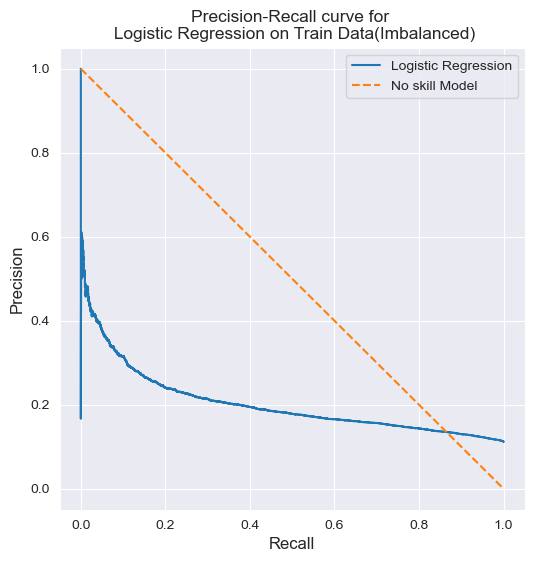

In [29]:
precision_train, recall_train, _ = precision_recall_curve(y_train,
                                                          Full_model.predict_log_proba(X_train)[:,1],)

fig,ax = plt.subplots(figsize=(6,6))
sns.set_style('darkgrid')
plt.plot(recall_train,precision_train,label='Logistic Regression')
sns.lineplot([1,0],[0,1],label='No skill Model',ls='--')
plt.xlabel("Recall",fontsize=12.0)
plt.ylabel("Precision",fontsize=12.0)
plt.axis()
plt.title('Precision-Recall curve for \n Logistic Regression on Train Data(Imbalanced)',fontsize=12.5)
plt.show()

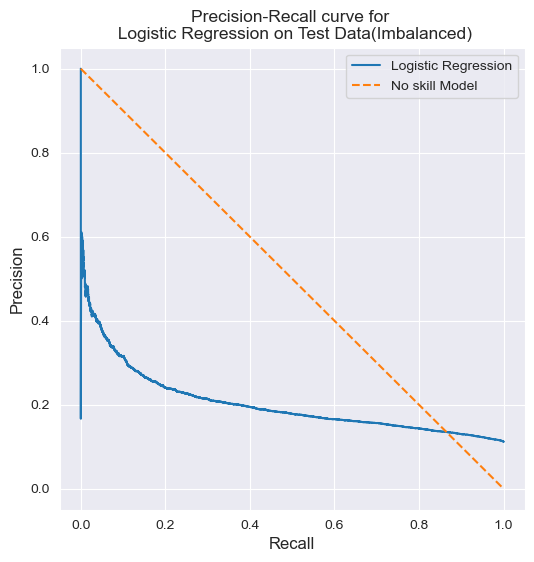

In [30]:
precision_test, recall_test, _ = precision_recall_curve(y_train,Full_model.predict_log_proba(X_train)[:,1])

fig,ax = plt.subplots(figsize=(6,6))
sns.set_style('darkgrid')
plt.plot(recall_test,precision_test,label='Logistic Regression')
sns.lineplot([1,0],[0,1],label='No skill Model',ls='--')
plt.xlabel("Recall",fontsize=12.0)
plt.ylabel("Precision",fontsize=12.0)
plt.axis()
plt.title('Precision-Recall curve for \n Logistic Regression on Test Data(Imbalanced)',fontsize=12.5)
plt.show()

In [31]:
# So the model is performing very bad (even worse than No skill classifier)

## `Tomek link undersampling`

In [32]:
tomek = TomekLinks()

predictor_tomek,target_tomek = tomek.fit_resample(df_log,Target_imbalanced)

In [33]:
predictor_tomek.shape

(97843, 110)

In [34]:
target_tomek.shape

(97843,)

In [35]:
# link_tomek = 'F:\GREAT LAKES\PROJECT\CAPSTONE\MODELING\Final_data_for_modeling\Tomek_link_undersampled_only_predictors.csv'
# link_tomek_target = 'F:\GREAT LAKES\PROJECT\CAPSTONE\MODELING\Final_data_for_modeling\Tomek_link_undersampled_only_target.csv'

In [36]:
# predictor_tomek.to_csv(link_tomek)
# target_tomek.to_csv(link_tomek_target)

In [37]:
Xtomek_train, Xtomek_test, ytomek_train, ytomek_test = split(predictor_tomek,target_tomek)

In [38]:
Xtomek_train.shape

(73382, 110)

In [39]:
logisitic_tomek = LogisticRegression(class_weight='balanced')

In [40]:
logisitic_tomek.fit(Xtomek_train,ytomek_train)

LogisticRegression(class_weight='balanced')

In [41]:
new_title = "Metrics for different Probability threshold \n (Logistic Regression) \n (Tomek link Undersampling with class_weight = 'balanced')"

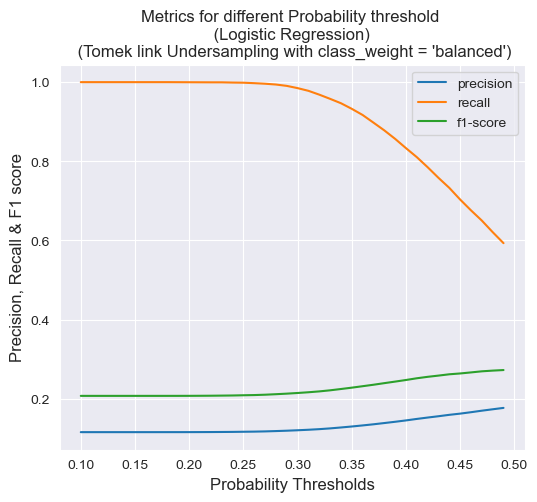

In [42]:
threshold_plot(logisitic_tomek,Xtomek_train,ytomek_train,title=new_title)

In [43]:
print(classification_report(ytomek_train,logisitic_tomek.predict(Xtomek_train)))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     64897
           1       0.18      0.56      0.27      8485

    accuracy                           0.65     73382
   macro avg       0.55      0.61      0.52     73382
weighted avg       0.84      0.65      0.71     73382



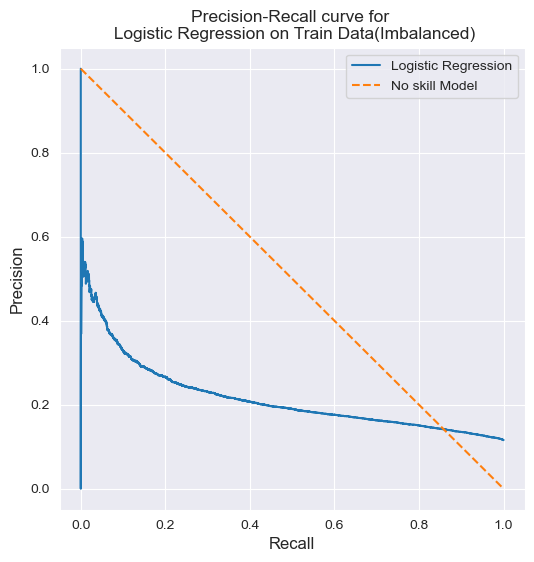

In [44]:
precision_tomek_train, recall_tomek_train, _ = precision_recall_curve(ytomek_train,logisitic_tomek.predict_proba(Xtomek_train)[:,1])

fig,ax = plt.subplots(figsize=(6,6))
sns.set_style('darkgrid')
plt.plot(recall_tomek_train,precision_tomek_train,label='Logistic Regression')
sns.lineplot([1,0],[0,1],label='No skill Model',ls='--')
plt.xlabel("Recall",fontsize=12.0)
plt.ylabel("Precision",fontsize=12.0)
plt.axis()
plt.title('Precision-Recall curve for \n Logistic Regression on Train Data(Imbalanced)',fontsize=12.5)
plt.show()

In [45]:
cv_report(logisitic_tomek,Xtomek_train,ytomek_train)

Metric            :  percentage
-----------------------------------
Balanced accuracy :  60.72 %
Precision         :  17.63 %
recall            :  55.04 %
F1-score          :  26.71 %


## `SMOTE-NC-Resampled`

In [29]:
# Importing already resampled data

log_nc = 'F:\GREAT LAKES\PROJECT\CAPSTONE\MODELING\Logistic regression\Final_data_for_modeling\Over_sampled_data(SMOTENC)_for_logistic_regression\SMOTENC_logistic_regression_reduced_size.csv'

In [30]:
df_nc = pd.read_csv(log_nc)
df_nc = df_nc.iloc[:,1:]

In [31]:
original_Target_nc = df_nc['readmitted'].copy()
Target_nc = df_nc[['readmitted']]
predictor_nc = df_nc.drop('readmitted',1)

In [32]:
def split_nc(predictor,Target,testing_size=0.25):
        X_train, X_test, y_train, y_test = train_test_split(predictor,Target,test_size=testing_size,
                                                    random_state=93)
        return X_train, X_test, y_train, y_test

In [33]:
def cv_report_nc(Model,Training_data,Target_balanced):
    X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_balanced,
                                                        test_size=0.25, random_state=42)
    ba = cross_val_score(Model,X_train,y_train,cv=5,
                         scoring='accuracy').mean()
    pr = cross_val_score(Model,X_train,y_train,cv=5,scoring='precision').mean()
    re = cross_val_score(Model,X_train,y_train,cv=5,scoring='recall').mean()
    f1 = cross_val_score(Model,X_train,y_train,cv=5,scoring='f1').mean()
    print("Metric            :  percentage")
    print("-"*35)
    print(f"Accuracy          :  {ba*100:0.2f} %")
    print(f"Precision         :  {pr*100:0.2f} %")
    print(f"recall            :  {re*100:0.2f} %")
    print(f"F1-score          :  {f1*100:0.2f} %")

In [34]:
Xnc_train, Xnc_test, ync_train, ync_test = split_nc(predictor_nc,Target_nc,testing_size=0.25)

In [35]:
logistic_nc = LogisticRegression(random_state=93)

In [36]:
logistic_nc.fit(Xnc_train,ync_train)

LogisticRegression(random_state=93)

In [37]:
print(classification_report(ync_train,logistic_nc.predict(Xnc_train)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     67220
           1       0.87      0.80      0.83     67286

    accuracy                           0.84    134506
   macro avg       0.84      0.84      0.84    134506
weighted avg       0.84      0.84      0.84    134506



In [55]:
cv_report_nc(logistic_nc,predictor_nc,Target_nc)

Metric            :  percentage
-----------------------------------
Accuracy          :  84.03 %
Precision         :  86.73 %
recall            :  80.26 %
F1-score          :  83.37 %


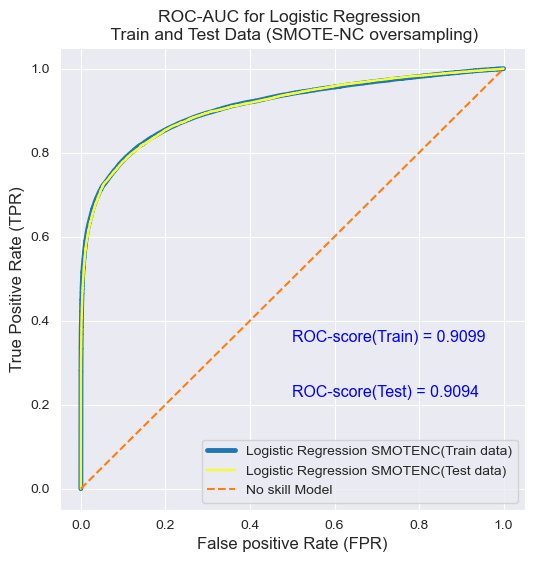

In [56]:
fpr, tpr, _ = roc_curve(ync_train,logistic_nc.predict_proba(Xnc_train)[:,1])
fpr1, tpr1, _ = roc_curve(ync_test,logistic_nc.predict_proba(Xnc_test)[:,1])

fig,ax = plt.subplots(figsize=(6,6))
sns.set_style('darkgrid')
plt.plot(fpr,tpr,label='Logistic Regression SMOTENC(Train data)',lw=3.5)
plt.plot(fpr1,tpr1,label='Logistic Regression SMOTENC(Test data)',c='#F3FC36',ls='-',lw=1.75)
sns.lineplot([0,1],[0,1],label='No skill Model',ls='--')
plt.xlabel("False positive Rate (FPR)",fontsize=12.0)
plt.ylabel("True Positive Rate (TPR)",fontsize=12.0)
plt.text(0.50,0.35,s=f"ROC-score(Train) = {roc_auc_score(ync_train,logistic_nc.predict_proba(Xnc_train)[:,1]):0.4f}",
        fontsize=11.5,color='blue')
plt.text(0.50,0.22,s=f"ROC-score(Test) = {roc_auc_score(ync_test,logistic_nc.predict_proba(Xnc_test)[:,1]):0.4f}",
        fontsize=11.5,color='blue')
plt.title('ROC-AUC for Logistic Regression \n Train and Test Data (SMOTE-NC oversampling)',fontsize=12.5)
plt.show()

In [57]:
Xnc_train.shape

(134506, 110)

In [58]:
ync_train.shape

(134506, 1)

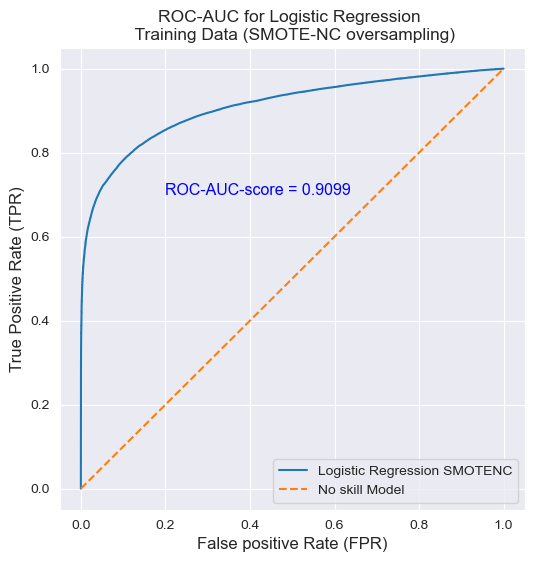

In [59]:
fpr, tpr, _ = roc_curve(ync_train,logistic_nc.predict_proba(Xnc_train)[:,1])

fig,ax = plt.subplots(figsize=(6,6))
sns.set_style('darkgrid')
plt.plot(fpr,tpr,label='Logistic Regression SMOTENC')
sns.lineplot([0,1],[0,1],label='No skill Model',ls='--')
plt.xlabel("False positive Rate (FPR)",fontsize=12.0)
plt.ylabel("True Positive Rate (TPR)",fontsize=12.0)
plt.text(0.2,0.7,s=f"ROC-AUC-score = {roc_auc_score(ync_train,logistic_nc.predict_proba(Xnc_train)[:,1]):0.4f}",
        fontsize=11.5,color='blue')
plt.title('ROC-AUC for Logistic Regression \n Training Data (SMOTE-NC oversampling)',fontsize=12.5)
plt.show()

In [60]:
# link_first_model = 'F:\GREAT LAKES\PROJECT\CAPSTONE\MODELING\Logistic regression\Final_data_for_modeling\Logistic_regression_model_nc\logistic_nc.pickle'

In [61]:
# import pickle
# with open(link_first_model,'wb') as model:
    # pickle.dump(logistic_nc,model)

In [62]:
title = "Metrics for different Probability threshold \n Logistic Regression (SMOTE-NC Oversampling)"

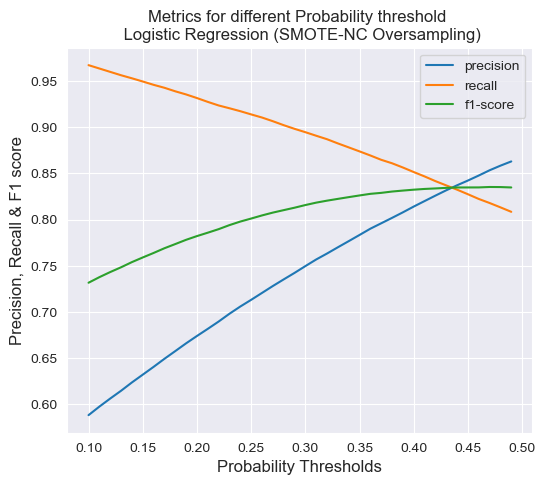

In [63]:
threshold_plot(logistic_nc,Xnc_train,ync_train,title=title)

## `SMOTE-NC-Resampled + Tomek-link undersampling`

In [38]:
# tomek_nc = TomekLinks()

# predictor_nc_tomek,Target_nc_tomek = tomek.fit_resample(predictor_nc_tomek,Target_nc_tomek)

# df_nc_tomek = pd.concat([predictor_nc_tomek,Target_nc_tomek],axis=1)
# df_nc_tomek.to_csv(link_tom)

In [39]:
link_tom = 'F:\GREAT LAKES\PROJECT\Different_datasets\Logistic_regression\Oversampling_tomek_link\log_nc_tomek.csv'

In [40]:
df_nc_tomek = pd.read_csv(link_tom)
df_nc_tomek = df_nc.iloc[:,1:]

In [41]:
Target_nc_tomek = df_nc_tomek[['readmitted']]
predictor_nc_tomek = df_nc_tomek.drop('readmitted',1)

In [42]:
Xnc_train, Xnc_test, ync_train, ync_test = split_nc(predictor_nc,Target_nc,testing_size=0.25)

In [43]:
logistic_nc_tomek = LogisticRegression(random_state=93)

In [44]:
logistic_nc_tomek.fit(Xnc_train,ync_train)

LogisticRegression(random_state=93)

In [45]:
print(classification_report(ync_train,logistic_nc_tomek.predict(Xnc_train)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     67220
           1       0.87      0.80      0.83     67286

    accuracy                           0.84    134506
   macro avg       0.84      0.84      0.84    134506
weighted avg       0.84      0.84      0.84    134506



In [ ]:
# So there is no change in the metrics

# `Feature Engineering`

In [46]:
link_smote = 'F:\GREAT LAKES\PROJECT\Different_datasets\Original_iterative_imputed_SMOTENC_data\Original_SMOTENC_after_imputation_1790000.csv'

In [47]:
df_smote = pd.read_csv(link_smote)
df_smote = df_smote.iloc[:,1:]

In [48]:
# Health_index = 1 / (number_emergency + number_inpatient + number_outpatient)
# severity_of_disease = (time_in_hospital(in days) + num_procedures + num_medications + num_lab_procedures + number_of_diagnoses)

In [49]:
# Based on frequency of patient’s visit to the hospital is high 
# then we can say that patient is less healthier and 
# less healthier patient tends to readmit quickly. 
# Higher the health_index lesser the chance that person will readmit (inversely proportional)

In [50]:
hospital_data = (df_smote['number_outpatient'] + df_smote['number_emergency'] + df_smote['number_inpatient'])
health_index = hospital_data

# for some of the patients there is no visit, hence denominator = 0 let's make health index as 1
health_index.loc[health_index == np.inf] = 1

### `severity of disease`

In [51]:
# Severity of disease  is the feature created based on time spent in hospital, 
# number of procedures, medications taken by patient. 
# For probabilistic interpretation we divided it by total values.

severity = (df_smote['time_in_hospital'] + df_smote['num_lab_procedures'] + df_smote['num_procedures'] + df_smote['num_medications'] + df_smote['number_diagnoses'])

severity_of_disease = severity

### `Therapy`

In [52]:
def medicine_taking(row):
    row = [0 if category == 'No' else 1 for category in row.tolist()]
    return row

def therapy(x):
    if x == 0:
        return 'No treatment'
    elif x == 1:
        return 'Monotherapy'
    else:
        return 'Combination therapy'

df_therapy = df_smote[feature_medicine].apply(medicine_taking)
Therapy = df_therapy.apply(np.sum,axis=1)
Therapy_df = pd.DataFrame(Therapy.apply(therapy),columns=['Therapy'])

In [54]:
health_index_std = health_index.to_frame().apply(zscore)
severity_of_disease_std = severity_of_disease.to_frame().apply(zscore)

In [55]:
# lets add 'severity index' & 'health_index' to SMOTE resampled data

predictor_nc_f = pd.concat([predictor_nc,health_index_std,severity_of_disease_std],axis=1)
Target_nc_f = Target_nc

In [56]:
# visual_feature['health_index'] = hospital_data
# visual_feature['severity_of_disease'] = severity
# visual_feature['readmitted'] = Target_nc_f

In [57]:
Xncf_train, Xncf_test, yncf_train, yncf_test = split_nc(predictor_nc_f,Target_nc_f,
                                                        testing_size=0.25)

In [58]:
logistic_nc_feature = LogisticRegression(random_state=93)
logistic_nc_feature.fit(Xncf_train,yncf_train)

LogisticRegression(random_state=93)

In [59]:
print(classification_report(yncf_train,logistic_nc_feature.predict(Xncf_train)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     67220
           1       0.89      0.81      0.85     67286

    accuracy                           0.85    134506
   macro avg       0.86      0.85      0.85    134506
weighted avg       0.86      0.85      0.85    134506



In [85]:
cv_report_nc(logistic_nc_feature,predictor_nc_f,Target_nc_f)

Metric            :  percentage
-----------------------------------
Accuracy          :  85.48 %
Precision         :  89.17 %
recall            :  80.67 %
F1-score          :  84.71 %


In [86]:
# only a slight improvement in recall

In [60]:
def classifier_report(Model,predictors,Actual,prob_threshold=0.5):
    predictions = np.where(Model.predict_proba(predictors)[:,1]>prob_threshold,1,0)
    print(classification_report(Actual,predictions))

In [61]:
def Balanced_metrics(Model,predictors,Actual,prob_threshold=0.5):
    predictions = np.where(Model.predict_proba(predictors)[:,1] > prob_threshold,1,0)
    f1 = f1_score(Actual,predictions)
    precision = precision_score(Actual,predictions)
    recall = recall_score(Actual,predictions)
    return precision,recall,f1

In [62]:
def threshold_plot(Model,X_train,y_train,title):
    probabilty_thresholds = np.arange(0.1,0.5,0.01)
    plotting_dict = dict()
    for prob in probabilty_thresholds:
        metric_1,metric_2,metric_3 = Balanced_metrics(Model,X_train,y_train,prob_threshold=prob)
        plotting_dict[prob] = metric_1,metric_2,metric_3

    plt.figure(figsize=(6,5))
    for label,values in zip(['precision','recall','f1-score'],list(zip(*tuple(plotting_dict.values())))):
        sns.lineplot(probabilty_thresholds,values,label=label)
    plt.title(title)
    plt.xlabel("Probability Thresholds",fontsize=12.0)
    plt.ylabel("Precision, Recall & F1 score",fontsize=12.0)
    return plt.show()

In [90]:
title = "Metrics for different Probability threshold \n (Logistic Regression) \n (Feature Engineering)"

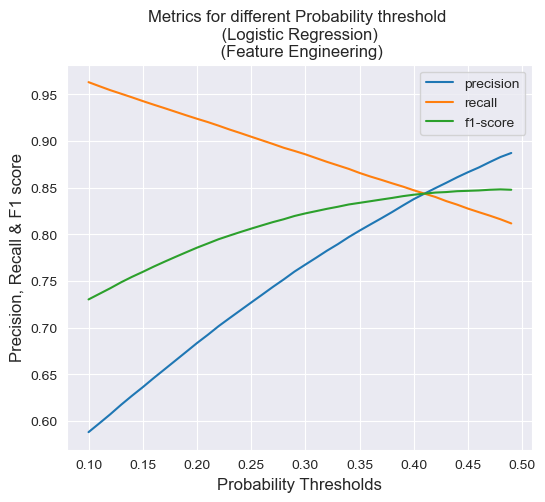

In [91]:
threshold_plot(logistic_nc_feature,Xncf_train,yncf_train,title)

In [65]:
chi_significant = []
for feature in predictor_nc.columns.difference(patient_info_numeric)[:-1]:
    p_value = stats.chi2_contingency(pd.crosstab(predictor_nc[feature],Target_nc.values.flatten()))[1]
    result = {True : "Significant",False : "Insignificant"}[p_value < 0.05]
    if result == 'Significant':
        chi_significant.append(feature)
        print(f"{feature:50s} : {result}")

A1Cresult_>8                                       : Significant
A1Cresult_None                                     : Significant
A1Cresult_Norm                                     : Significant
acarbose_No                                        : Significant
acarbose_Steady                                    : Significant
admission_source_id_Referral                       : Significant
admission_source_id_other                          : Significant
admission_type_id_Emergency                        : Significant
admission_type_id_No mention                       : Significant
admission_type_id_Urgent                           : Significant
admission_type_id_others                           : Significant
age_[10-20)                                        : Significant
age_[20-30)                                        : Significant
age_[30-40)                                        : Significant
age_[40-50)                                        : Significant
age_[50-60)              

In [93]:
len(chi_significant)

96

In [66]:
Xnc_train, Xnc_test, ync_train, ync_test = split_nc(predictor_nc[chi_significant+patient_info_numeric],Target_nc,testing_size=0.25)

In [67]:
logistic_chi_nc = LogisticRegression(random_state=93)
logistic_chi_nc.fit(Xnc_train,ync_train)

LogisticRegression(random_state=93)

In [96]:
print(classification_report(ync_train,logistic_chi_nc.predict(Xnc_train)))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     67220
           1       0.84      0.81      0.82     67286

    accuracy                           0.83    134506
   macro avg       0.83      0.83      0.83    134506
weighted avg       0.83      0.83      0.83    134506



In [97]:
cv_report_nc(logistic_nc,Xnc_train,ync_train)

Metric            :  percentage
-----------------------------------
Accuracy          :  82.54 %
Precision         :  83.77 %
recall            :  80.69 %
F1-score          :  82.20 %


## `Select K Best categorical features using chi2`

In [68]:
# Taking significant variables from chi-square test performed above

kbest = SelectKBest(score_func=chi2,k=75)

kbest.fit(predictor_nc[chi_significant],Target_nc)

SelectKBest(k=75, score_func=<function chi2 at 0x00000195776CD430>)

In [69]:
logistic_kbest = LogisticRegression(random_state=93)
logistic_kbest.fit(Xnc_train[list(kbest.get_feature_names_out())+patient_info_numeric],ync_train)

LogisticRegression(random_state=93)

In [70]:
len(list(kbest.get_feature_names_out()))

75

In [101]:
k_best_and_numeric = list(kbest.get_feature_names_out())+patient_info_numeric
print(classification_report(ync_train,logistic_kbest.predict(Xnc_train[k_best_and_numeric])))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80     67220
           1       0.80      0.81      0.81     67286

    accuracy                           0.81    134506
   macro avg       0.81      0.81      0.81    134506
weighted avg       0.81      0.81      0.81    134506



##  `Select K Best categorical features using f_classif()`
## `Annova F measure`

In [71]:
from sklearn.feature_selection import f_oneway,f_classif

In [72]:
# Taking significant variables from chi-square test performed above

kbest_numeric = SelectKBest(score_func=f_oneway,k=4)

kbest_numeric.fit(predictor_nc[patient_info_numeric],Target_nc)

SelectKBest(k=4, score_func=<function f_oneway at 0x00000195776CD280>)

In [73]:
kbest_numeric.get_feature_names_out()

array(['num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient'], dtype=object)

In [74]:
log_number = LogisticRegression(random_state=93)
log_number.fit(Xnc_train[kbest_numeric.get_feature_names_out()],ync_train)

LogisticRegression(random_state=93)

In [75]:
print(classification_report(ync_train,log_number.predict(Xnc_train[kbest_numeric.get_feature_names_out()])))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54     67220
           1       0.54      0.54      0.54     67286

    accuracy                           0.54    134506
   macro avg       0.54      0.54      0.54    134506
weighted avg       0.54      0.54      0.54    134506



## `Recursive Feature Elimination`

In [76]:
rfe = RFE(estimator=LogisticRegression(random_state=93),n_features_to_select=50)
rfe.fit(predictor_nc,Target_nc)

RFE(estimator=LogisticRegression(random_state=93), n_features_to_select=50)

In [77]:
Xnc_train, Xnc_test, ync_train, ync_test = split_nc(predictor_nc,Target_nc,testing_size=0.25)

In [78]:
logistic_rfe = LogisticRegression(random_state=93)
logistic_rfe.fit(Xnc_train[rfe.get_feature_names_out()],ync_train)

LogisticRegression(random_state=93)

In [79]:
print(classification_report(ync_train,logistic_rfe.predict(Xnc_train[rfe.get_feature_names_out()])))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     67220
           1       0.84      0.76      0.80     67286

    accuracy                           0.81    134506
   macro avg       0.81      0.81      0.81    134506
weighted avg       0.81      0.81      0.81    134506



In [80]:
print(classification_report(ync_test,logistic_rfe.predict(Xnc_test[rfe.get_feature_names_out()])))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82     22451
           1       0.84      0.76      0.80     22385

    accuracy                           0.81     44836
   macro avg       0.81      0.81      0.81     44836
weighted avg       0.81      0.81      0.81     44836



## ` Model with only continuous features`

In [81]:
df_numeric = df[patient_info_numeric].copy()

In [82]:
df_numeric.var()

time_in_hospital        8.875642
num_lab_procedures    386.695034
num_procedures          2.918038
num_medications        66.099439
number_outpatient       1.608991
number_emergency        0.869825
number_inpatient        1.591438
number_diagnoses        3.749458
dtype: float64

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df_numeric, Target_imbalanced, test_size=0.25, random_state=42)

In [84]:
Numeric_model = LogisticRegression(class_weight='balanced',random_state=93)
Numeric_model.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', random_state=93)

In [85]:
print(classification_report(y_test,Numeric_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80     22372
           1       0.17      0.47      0.25      2875

    accuracy                           0.68     25247
   macro avg       0.54      0.59      0.52     25247
weighted avg       0.83      0.68      0.73     25247



### Oversampling using SMOTE

In [86]:
smote = SMOTE(sampling_strategy=1,k_neighbors=5)

predictor_smote,target_smote = smote.fit_resample(df_numeric.apply(zscore),Target_imbalanced)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(predictor_smote,target_smote,test_size=0.25,
                                                    random_state=42)

In [87]:
Numeric_model_smote1 = LogisticRegression()
Numeric_model_smote1.fit(Xs_train,ys_train)
print(classification_report(ys_test,Numeric_model_smote1.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.57      0.70      0.63     22248
           1       0.62      0.48      0.54     22588

    accuracy                           0.59     44836
   macro avg       0.59      0.59      0.58     44836
weighted avg       0.59      0.59      0.58     44836



### Oversampling using Adaptive Synthetic (ADASYN) algorithm

In [88]:
smote = ADASYN(sampling_strategy=0.99,n_neighbors=10,random_state=39)

predictor_adasyn,target_adasyn = smote.fit_resample(df_numeric.apply(zscore),Target_imbalanced)
Xa_train, Xa_test, ya_train, ya_test = train_test_split(predictor_adasyn,target_adasyn,test_size=0.25,
                                                    random_state=42)
Numeric_model_smote = LogisticRegression()
Numeric_model_smote.fit(Xa_train,ya_train)
print(classification_report(ya_test,Numeric_model_smote.predict(Xa_test)))

              precision    recall  f1-score   support

           0       0.56      0.71      0.63     22254
           1       0.60      0.44      0.51     21956

    accuracy                           0.58     44210
   macro avg       0.58      0.58      0.57     44210
weighted avg       0.58      0.58      0.57     44210



### Over-sampling using Borderline SMOTE.

In [89]:
smote = BorderlineSMOTE(random_state=39,sampling_strategy=0.85,k_neighbors=12)

predictor_bsmote,target_bsmote = smote.fit_resample(df_numeric.apply(zscore),Target_imbalanced)
Xbs_train, Xbs_test, ybs_train, ybs_test = train_test_split(predictor_bsmote
                                                    ,target_bsmote,test_size=0.25,
                                                    random_state=42)
Numeric_model_smote = LogisticRegression()
Numeric_model_smote.fit(Xbs_train,ybs_train)
print(classification_report(ybs_test,Numeric_model_smote.predict(Xbs_test)))

              precision    recall  f1-score   support

           0       0.60      0.81      0.69     22166
           1       0.64      0.39      0.48     19307

    accuracy                           0.61     41473
   macro avg       0.62      0.60      0.59     41473
weighted avg       0.62      0.61      0.59     41473



### oversampling using K-Means-SMOTE

In [90]:
link_smote = 'F:\GREAT LAKES\PROJECT\CAPSTONE\Iterative_Imputatiof_diagnosis\Fully_finally_imputed_data.csv'

df_smote = pd.read_csv(link_smote)
df_smote = df_smote.iloc[:,1:]

# Health_index = 1 / (number_emergency + number_inpatient + number_outpatient)
# severity_of_disease = (time_in_hospital(in days) + num_procedures + num_medications + num_lab_procedures + number_of_diagnoses)

# Based on frequency of patient’s visit to the hospital is high 
# then we can say that patient is less healthier and 
# less healthier patient tends to readmit quickly. 
# Higher the health_index lesser the chance that person will readmit (inversely proportional)

hospital_data = (df_smote['number_outpatient'] + df_smote['number_emergency'] + df_smote['number_inpatient'])
health_index = hospital_data

# for some of the patients there is no visit, hence denominator = 0 let's make health index as 1
health_index.loc[health_index == np.inf] = 1

# Severity of disease  is the feature created based on time spent in hospital, 
# number of procedures, medications taken by patient. 
# For probabilistic interpretation we divided it by total values.

severity = (df_smote['time_in_hospital'] + df_smote['num_lab_procedures'] + df_smote['num_procedures'] + df_smote['num_medications'] + df_smote['number_diagnoses'])

severity_of_disease = severity

health_index_std = pd.DataFrame(health_index,columns=['Health_index'])
severity_of_disease_std = pd.DataFrame(severity_of_disease,columns=['Severity_of_disease'])

new_numeric = pd.concat([df_numeric,health_index_std,severity_of_disease_std],axis=1)

In [91]:
over_sample = KMeansSMOTE(cluster_balance_threshold=0.134,random_state=55,k_neighbors=12,
                          sampling_strategy=0.99,)
predictor_balanced,Target_balanced = over_sample.fit_resample(new_numeric.apply(zscore),Target_imbalanced)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(predictor_balanced,Target_balanced,
                                                        test_size=0.25,random_state=42)

In [92]:
predictor_balanced.shape

(178446, 10)

In [93]:
Log_kmeans = LogisticRegression(random_state=93)
Log_kmeans.fit(Xb_train,yb_train)

LogisticRegression(random_state=93)

In [94]:
print(classification_report(yb_train,Log_kmeans.predict(Xb_train)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     67431
           1       0.90      0.89      0.90     66403

    accuracy                           0.90    133834
   macro avg       0.90      0.90      0.90    133834
weighted avg       0.90      0.90      0.90    133834



In [102]:
print(classification_report(yb_test,Log_kmeans.predict(Xb_test)))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22240
           1       0.90      0.89      0.90     22372

    accuracy                           0.90     44612
   macro avg       0.90      0.90      0.90     44612
weighted avg       0.90      0.90      0.90     44612



In [ ]:
# 5-Fold cross validation reports

In [103]:
cv_report_nc(Log_kmeans,Xb_train,yb_train)

Metric            :  percentage
-----------------------------------
Accuracy          :  89.99 %
Precision         :  90.37 %
recall            :  89.39 %
F1-score          :  89.88 %


In [ ]:
link_model = 'F:\GREAT LAKES\PROJECT\CAPSTONE\MODELING\Logistic regression\Final_data_for_modeling\Logistic regression_numeric_model\log_numeric.pickle'
import pickle
with open(link_model,'wb') as numeric:
    pickle.dump(pipeline,numeric)

In [222]:
title = 'K-Means SMOTE oversampling \n (Logistic Regression Oversampled data only numeric predictors)'

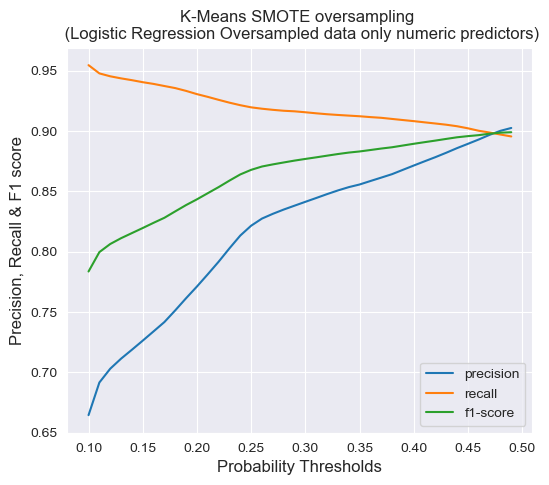

In [224]:
probabilty_thresholds = np.arange(0.1,0.5,0.01)
plotting_dict = dict()
for prob in probabilty_thresholds:
    metric_1,metric_2,metric_3 = Balanced_metrics(Log_kmeans,Xb_train,yb_train,prob_threshold=prob)
    plotting_dict[prob] = metric_1,metric_2,metric_3

plt.figure(figsize=(6,5))
for label,values in zip(['precision','recall','f1-score'],list(zip(*tuple(plotting_dict.values())))):
    sns.lineplot(probabilty_thresholds,values,label=label)
plt.title(title)
plt.xlabel("Probability Thresholds",fontsize=12.0)
plt.ylabel("Precision, Recall & F1 score",fontsize=12.0)
plt.legend(loc='lower right')
plt.show()

### `Polynomial features`

In [97]:
Poly = PolynomialFeatures(degree=2)
Log_reg = LogisticRegression(random_state=93)

pipeline = Pipeline([('Polynomial2',Poly),('Logistic_regression',Log_reg)])

In [99]:
pipeline.fit(Xb_train,yb_train)

Pipeline(steps=[('Polynomial2', PolynomialFeatures()),
                ('Logistic_regression', LogisticRegression(random_state=93))])

In [100]:
print(classification_report(yb_train,pipeline.predict(Xb_train)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     67431
           1       0.90      0.90      0.90     66403

    accuracy                           0.90    133834
   macro avg       0.90      0.90      0.90    133834
weighted avg       0.90      0.90      0.90    133834



In [101]:
print(classification_report(yb_test,pipeline.predict(Xb_test)))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     22240
           1       0.89      0.90      0.90     22372

    accuracy                           0.90     44612
   macro avg       0.90      0.90      0.90     44612
weighted avg       0.90      0.90      0.90     44612



In [105]:
cv_report_nc(pipeline.named_steps['Logistic_regression'],Xb_train,yb_train)

Metric            :  percentage
-----------------------------------
Accuracy          :  89.99 %
Precision         :  90.37 %
recall            :  89.39 %
F1-score          :  89.88 %
